# Защита персональных данных клиентов

Страховой компании необходимо защитить данные клиентов. Для этого требуется разработать такой метод преобразования данных, по которому будет сложно восстановить персональную информацию. 
Важно, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. 

Исследование будет проходить в несколько этапов:
- изучение и предобработка данных;
- описание метода преобразования данных;
- проверка алгоритма преобразования с помощью расчетов;
- создание и обучение модели, получение предсказаний;
- расчет метрики качества для модели до преобразования;
- обучение модели и получение предсказаний на преобразованных данных;
- расчет метрики качества для модели, обученной на преобразованых данных;
- отчет

## 1 Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/datasets/insurance.csv')

In [3]:
df.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


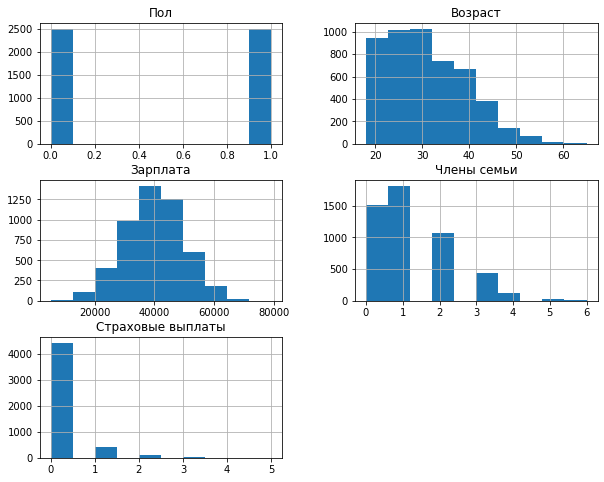

In [5]:
# смотрю на распределения признаков
df.hist(figsize=(10,8));

Распределение только одного признака (Зарплата) близко к нормальному

In [6]:
df['Возраст'] = df['Возраст'].astype('int')

In [7]:
df.duplicated().sum()

153

In [8]:
# Поскольку линейные модели чувствительны к скоррелированности признаков, считаю коэффициент корреляции.
# Предварительно удалю категориальный признак (пол)
df_for_corr = df.drop(columns='Пол')
df_for_corr.corr(method='spearman')

,Возраст,Зарплата,Члены семьи,Страховые выплаты
Возраст,1.000000,-0.020238,-0.001503,0.548589
Зарплата,-0.020238,1.000000,-0.025492,-0.005549
Члены семьи,-0.001503,-0.025492,1.000000,-0.029210
Страховые выплаты,0.548589,-0.005549,-0.029210,1.000000


Вывод: в данных отсутствуют пропуски, типы данных во всех столбцах, кроме столбца "Возраст", соответствуют содержимому. Тип данных в столбце "Возраст" изменен на целочисленный. В данных имеются явные дубликаты, удаление полагаю нецелесообразным, поскольку возможно допустить ситуацию, когда среди клиентов будут люди одного возраста, с одинаковой зарплатой и составом семьи. Признаки для обучения слабо скоррелированы между собой. 

## 2 Алгоритм преобразования

**Алгоритм**
для преобразования данных:
1. Создам случайную матрицу Р, длина которой равна числу признаков обучающей выборки;
2. Проверю, что полученная матрица обратима (покажу, что ее определитель отличен от нуля);
3. Умножу матрицу с обучающими признаками на полученную случайную матрицу;

Вначале создам модель линейной регрессии, обучу ее и расчитаю метрику качества R2 до преобразования

In [25]:
# выделяю обучающие признаки
features = df.drop('Страховые выплаты', axis=1)
# выделяю целевой признак
target = df['Страховые выплаты']

In [26]:
# создаю класс 
class LinearRegression:
# пишу метод для обучения модели    
    def fit(self, features,target):
        X = np.concatenate((np.ones((features.shape[0], 1)), features), axis=1) 
        y = target
# использую формулу для обучения        
        w = ((np.linalg.inv(X.T.dot(X))).dot(X.T)).dot(y) 
        self.w = w[1:]
        self.w0 = w[0]
# напишу метод для предказания с использованием формулы     
    def predict(self, features):
        return features.dot(self.w) + self.w0

In [27]:
# обучу модель на непреобразованных данных
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print('Качество предсказаний модели до преобразования данных:', r2_score(target, predictions))


Качество предсказаний модели до преобразования данных: 0.42494550286668


## 3 Проверка алгоритма

In [28]:
# создадю случайную матрицу, ее длина должна быть равна ширине тренировочной выборки (числу features)
P = np.random.normal(size=(4,4))
# матрица должна быть обратимой 
# поскольку матрица обратима тогда, когда ее определитель отличен от нуля, рассчитаю определитель
print('Определитель случайной матрицы равен', np.linalg.det(P))


Определитель случайной матрицы равен 0.9675076710341921


Созданная случайная матрица Р обратима, далее умножаю признаки на нее, обучиму модель, сделаю предсказания и рассчитаю метрику.

In [29]:
features_new = features.dot(P)
model = LinearRegression()
model.fit(features_new, target)
predictions = model.predict(features_new)
print('Качество предсказаний модели на преобразованных данных:', r2_score(target, predictions))

Качество предсказаний модели на преобразованных данных: 0.424945502866686


Метрика R2 для модели, обученной на исходных данных, совпадает с метрикой для модели, обученной на преобразованных данных. Иными словами, преобразование данных не отразилось на качестве модели линейной регрессии

Выводы:
- в ходе исследования я изучила и предобработала сведения о страховых выплатах клиентам;
- для защиты персональных данных предложила алгоритм, предполагающий умножение признаков (данных) клиентов на случайную обратимую матрицу;
- модель линейной регрессии обучила на исходных данных, получила предсказания и рассчитала метрику качества R2;
- модель линейной регрессии обучила на преобразованных данных, получила предсказания и рассчитала метрика качества R2;
- по результатам показала, что метрика качества в обоих случаях совпадает, следовательно, предложенный способ преобразования  может быть использован для защиты данных клиентов.